## Testing Speed of various approaches

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import warnings

# --- Required Libraries ---
try:
    import cupy as cp
    from cuml.manifold import UMAP as UMAP_cuml
    import umap as umap_cpu
except ImportError as e:
    print(f"Error importing a required library: {e}")
    print("Please ensure umap-learn, cuml, and cupy are installed.")
    exit()

warnings.filterwarnings('ignore', category=FutureWarning)

# --- Data Loading ---
# Ensure these paths are correct for your environment
data_path1 = Path('./files/llb3_fold1.npz')
data_path2 = Path('./files/llb3_fold2.npz')
data_path3 = Path('./files/llb3_fold3.npz')
for p in [data_path1, data_path2, data_path3]:
    if not p.exists():
        raise FileNotFoundError(f"Data file not found at: {p}. Please adjust the path.")

with np.load(data_path1) as f1, np.load(data_path2) as f2, np.load(data_path3) as f3:
    emb1 = f1["predictions"][:1_000_000]
    emb2 = f2["predictions"][:1_000_000]
    emb3 = f3["predictions"][:1_000_000]
    source_embeddings = np.concatenate([emb1, emb2, emb3], axis=0)

# --- Benchmark Configuration ---
dataset_sizes = [10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000]
output_file = Path("umap_benchmark_results.csv")

# UMAP parameters
umap_params_cpu = {
    'n_neighbors': 50,
    'n_components': 8,
    'min_dist': 0.1,
    'metric': 'euclidean',
    'low_memory': True,
    'n_jobs': -1,
}
umap_params_gpu = {
    'n_neighbors': 50,
    'n_components': 8,
    'min_dist': 0.1,
    'metric': 'euclidean',
    'output_type': 'cupy',
    'build_kwds': {'build_algo': 'brute_force_knn'}
}
results = []

# --- Run Benchmark ---
print("Starting UMAP performance benchmark...")
for n in dataset_sizes:
    print(f"  Processing size: {n:,} frames...")
    data_subset = source_embeddings[:n]

    # 1. CPU UMAP Benchmark
    t0_cpu = time.perf_counter()
    umap_model_cpu = umap_cpu.UMAP(**umap_params_cpu, random_state=42)
    umap_model_cpu.fit_transform(data_subset)
    t1_cpu = time.perf_counter()
    total_time_cpu = t1_cpu - t0_cpu
    results.append({'size': n, 'method': 'CPU UMAP', 'total_time': total_time_cpu})
    print(f"    CPU UMAP total time: {total_time_cpu:.4f} s")

    # 2. GPU (cuML) UMAP Benchmark
    data_gpu = cp.asarray(data_subset)
    t0_gpu = time.perf_counter()
    umap_model_gpu = UMAP_cuml(**umap_params_gpu)
    umap_model_gpu.fit_transform(data_gpu)
    t1_gpu = time.perf_counter()
    total_time_gpu = t1_gpu - t0_gpu
    results.append({'size': n, 'method': 'cuML UMAP (GPU)', 'total_time': total_time_gpu})
    print(f"    cuML UMAP total time: {total_time_gpu:.4f} s")

# --- Save Results ---
df_results = pd.DataFrame(results)
df_results.to_csv(output_file, index=False)
print(f"\nBenchmark complete. Results saved to '{output_file}'")

Starting UMAP performance benchmark...
  Processing size: 10,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 33.1337 s
[2025-06-18 14:44:49.493] [CUML] [info] Building knn graph using brute force
    cuML UMAP total time: 0.1692 s
  Processing size: 50,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 95.2308 s
[2025-06-18 14:46:24.908] [CUML] [info] Building knn graph using brute force
    cuML UMAP total time: 0.4438 s
  Processing size: 100,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 180.7060 s
[2025-06-18 14:49:26.086] [CUML] [info] Building knn graph using nn descent
    cuML UMAP total time: 1.4233 s
  Processing size: 250,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 460.3154 s
[2025-06-18 14:57:07.881] [CUML] [info] Building knn graph using nn descent
    cuML UMAP total time: 3.6593 s
  Processing size: 500,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 1138.4359 s
[2025-06-18 15:16:10.065] [CUML] [info] Building knn graph using nn descent
    cuML UMAP total time: 7.0158 s
  Processing size: 1,000,000 frames...


/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    CPU UMAP total time: 2524.2712 s
[2025-06-18 15:58:21.511] [CUML] [info] Building knn graph using nn descent
    cuML UMAP total time: 13.1547 s

Benchmark complete. Results saved to 'umap_benchmark_results.csv'


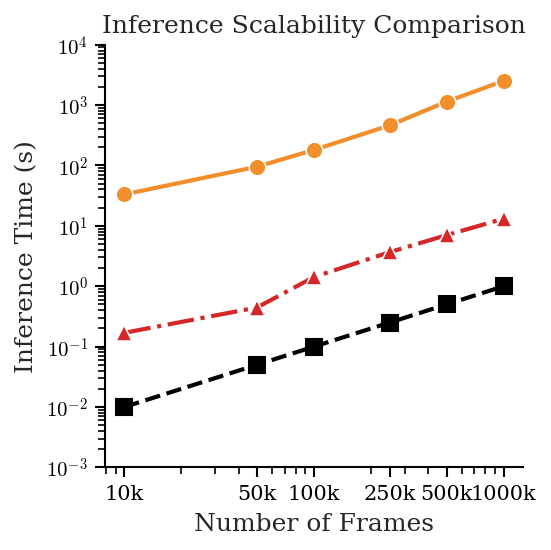

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# --- Configuration & Style ---
results_file = Path("umap_benchmark_results.csv")
decoder_time_per_frame_const = 1e-6

# Check if the results file exists
if not results_file.exists():
    raise FileNotFoundError(
        f"Results file not found at: '{results_file}'. "
        "Please run the computation script first to generate this file."
    )

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper")
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif'],
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': 'grey',
    'grid.linestyle': ':',
    'grid.alpha': 0.5,
    'figure.dpi': 150,
})

# --- Data Loading and Processing ---
df_results = pd.read_csv(results_file)

# Calculate time per frame from total time and size.
df_results['time_per_frame'] = df_results['total_time']

# --- Plotting ---
fig, ax = plt.subplots(figsize=(3.75, 3.75))

style_map = {
    'CPU UMAP': {'color': '#f28e2b', 'marker': 'o', 'linestyle': '-'},
    'cuML UMAP (GPU)': {'color': '#d62728', 'marker': '^', 'linestyle': '-.'},
}

methods = df_results['method'].unique()
palette = [style_map[m]['color'] for m in methods]
markers = [style_map[m]['marker'] for m in methods]
dashes = [style_map[m]['linestyle'] for m in methods]

g = sns.lineplot(
    data=df_results,
    x='size',
    y='time_per_frame',
    hue='method',
    palette=palette,
    ax=ax,
    linewidth=2,
    legend=False,
)

for i, line in enumerate(ax.get_lines()):
    if i < len(methods):
        line.set_marker(markers[i])
        line.set_linestyle(dashes[i])
        line.set_markersize(8)

# Add decoder baseline as a line with points at all x positions
unique_sizes = sorted(df_results['size'].unique())
decoder_times = [decoder_time_per_frame_const * n for n in unique_sizes]
ax.plot(
    unique_sizes,
    decoder_times,
    color='k',
    marker='s',
    linestyle='--',
    linewidth=2,
    markersize=8,
    label='_nolegend_'
)

# --- Axes and Labels Formatting ---
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of Frames')
ax.set_ylabel('Inference Time (s)')
ax.set_title('Inference Scalability Comparison')

ax.set_xticks(unique_sizes)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k' if x in unique_sizes else ''))

# Set y-ticks only at powers of 10 within the data range, to reduce clutter but show OOM traversal
ymin, ymax = ax.get_ylim()
# Find the nearest powers of 10 that cover the data range
y_tick_min = 10 ** np.floor(np.log10(ymin))
y_tick_max = 10 ** np.ceil(np.log10(ymax))
# Generate ticks at each power of 10 within this range
yticks = []
val = y_tick_min
while val <= y_tick_max:
    yticks.append(val)
    val *= 10
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, p: f'$10^{{{int(np.log10(y))}}}$' if y in yticks else ''))

ax.tick_params(axis='both', which='both', direction='out')

ax.grid(False)

if hasattr(ax, "legend_") and ax.legend_ is not None:
    ax.legend_.remove()

plt.tight_layout(pad=1.0)
plt.savefig("umap_performance_comparison_square.pdf", bbox_inches='tight')
plt.show()

## Creating Fit + Transform Figures

In [3]:
import pathlib
import numpy as np
import cupy as cp
from cuml.manifold import UMAP as UMAP_cuml
import matplotlib.pyplot as plt

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files_with_teacher_labels_no_smoothing"
SAVE_DIR = ROOT / "results"
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Pick a bird and two folds
BIRD = "llb3"
FOLD_FIT_IDX = 0
FOLD_TRANSFORM_IDX = 1

FOLD_FILES = [
    f"{BIRD}_fold1.npz",
    f"{BIRD}_fold5.npz",
]
# Using a larger N since this will be fast now
MAX_FRAMES = 1_000_000

# --- Load embeddings and labels for the two folds ---
in_path_fit = NPZ_DIR / FOLD_FILES[FOLD_FIT_IDX]
in_path_transform = NPZ_DIR / FOLD_FILES[FOLD_TRANSFORM_IDX]

with np.load(in_path_fit) as f:
    embeddings_fit = f["predictions"][:MAX_FRAMES]
    labels_fit = f["ground_truth_labels"][:MAX_FRAMES]
with np.load(in_path_transform) as f:
    embeddings_transform = f["predictions"][:MAX_FRAMES]
    labels_transform = f["ground_truth_labels"][:MAX_FRAMES]

# --- Fit UMAP on the first fold ---
print("Fitting UMAP on fold:", FOLD_FILES[FOLD_FIT_IDX])
emb_fit_gpu = cp.asarray(embeddings_fit)
umap_cuml = UMAP_cuml(n_neighbors=50, n_components=2, min_dist=0.1, metric="euclidean", init="spectral", n_epochs=200)
# The fit_transform output is already a cupy array
z_umap_fit = umap_cuml.fit_transform(emb_fit_gpu)

# --- Transform the second fold using the fitted UMAP ---
print("Transforming fold:", FOLD_FILES[FOLD_TRANSFORM_IDX])
emb_transform_gpu = cp.asarray(embeddings_transform)
# The transform output is also already a cupy array
z_umap_transform = umap_cuml.transform(emb_transform_gpu)

z_umap_fit_np = cp.asnumpy(z_umap_fit)
z_umap_transform_np = cp.asnumpy(z_umap_transform)

# --- Save UMAP coordinates and labels for both folds ---

np.savez(SAVE_DIR / "fit_umap_train.npz", coords=z_umap_fit_np, labels=labels_fit)

np.savez(SAVE_DIR / "transform_umap_test.npz", coords=z_umap_transform_np, labels=labels_transform)

Fitting UMAP on fold: llb3_fold1.npz
Transforming fold: llb3_fold5.npz
[2025-06-18 10:33:08.369] [CUML] [info] Transform can only be run with brute force. Using brute force.


## Compare Logits on held out set 

In [1]:
import sys
import pathlib
import shutil
import time
import gc
from collections import Counter
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from umap import UMAP

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files_with_teacher_labels_no_smoothing"
SAVE_DIR = ROOT / "results" / "decoder_softmax_umap" # Changed save dir
if SAVE_DIR.exists():
    shutil.rmtree(SAVE_DIR) # Clean up previous runs
SAVE_DIR.mkdir(parents=True)

MAX_FRAMES = 1_000_000
CTX = 1_000
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = ROOT / "experiments" / "TweetyBERT_Paper_Yarden_Model"

# --- helpers: i/o + tiny utils ---
def load_npz(fp: pathlib.Path) -> Tuple[np.ndarray, ...]:
    with np.load(fp) as f:
        return ( # Return spectrograms, teacher labels, and ground truth
            f["s"][:MAX_FRAMES],
            f["hdbscan_labels"][:MAX_FRAMES],
            f["ground_truth_labels"][:MAX_FRAMES],
        )

# --- helpers: decoder forward ---
sys.path.insert(0, str(pathlib.Path("src").resolve()))
from src.decoder import TweetyBertClassifier,SongDataSet_Image, CollateFunction

## For evalulation of decoder performance
def run_decoder(model_torch: torch.nn.Module,
                specs: np.ndarray,
                gt: np.ndarray,
                tmp_dir: pathlib.Path) -> Tuple[np.ndarray, float, np.ndarray]:
    tmp_dir.mkdir(parents=True, exist_ok=True)
    seg_id = 0
    for start in range(0, len(specs), CTX):
        seg = specs[start:start + CTX]
        seg = np.pad(seg, ((0, 0), (20, 0)), constant_values=0)
        if seg.shape[0] < CTX:
            seg = np.pad(seg, ((0, CTX - seg.shape[0]), (0, 0)))
        gt_seg = gt[start:start + CTX]
        if gt_seg.shape[0] < CTX:
            gt_seg = np.pad(gt_seg, (0, CTX - gt_seg.shape[0]))
        # write the slice so the dataset isn't empty
        np.savez(
            tmp_dir / f"{seg_id}.npz",
            labels=gt_seg,
            s=seg.T,                        # freq × time, per decoder expectations
            vocalization=np.zeros(CTX, dtype=np.int8)
        )
        seg_id += 1

    if seg_id == 0:
        raise RuntimeError("no segments saved – tmp_dir empty")

    ds = SongDataSet_Image(tmp_dir,
                           num_classes=int(gt.max()) + 1,
                           segment_length=CTX,
                           infinite_loader=False)
    dl = DataLoader(ds, batch_size=1, shuffle=False,
                    collate_fn=CollateFunction(segment_length=CTX))

    preds, logits_accum, gts_accum = [], [], []
    t0 = time.perf_counter()
    model_torch.eval()
    with torch.no_grad():
        for b in dl:
            s = b[0].to(DEV)           # first element = spectrogram tensor
            gt = b[1].to(DEV)
            logits = model_torch(s)          # (1, S, C)
            preds.append(torch.argmax(logits, 2).cpu().numpy())
            logits_accum.append(logits.cpu().numpy())        # (1, S, C)
            gts_accum.append(torch.argmax(gt, 2).cpu().numpy())

    t_elapsed = time.perf_counter() - t0

    shutil.rmtree(tmp_dir, ignore_errors=True)
    preds   = np.concatenate([p.squeeze(0) for p in preds])[:len(specs)]
    logits  = np.concatenate([l.squeeze(0) for l in logits_accum])[:len(specs)]
    gts     = np.concatenate([g.squeeze(0) for g in gts_accum])[:len(specs)]

    return preds, t_elapsed, logits, gts 

# --- driver ---
if __name__ == "__main__":
    # --- 1. Configuration ---
    BIRD_ID = 'llb3'
    TRAIN_FILE = f'{BIRD_ID}_fold1.npz'
    TEST_FILE = f'{BIRD_ID}_fold5.npz'
    DECODER_CONFIG = {'name': 'mlp_weighted', 'classifier_type': 'decoder', 'use_weights': True}
    print("--- Configuration ---")
    print(f"Bird: {BIRD_ID}, Train on: {TRAIN_FILE}, Test on: {TEST_FILE}")

    # --- 2. Train Decoder on Fold 1 ---
    fit_path = NPZ_DIR / TRAIN_FILE
    _, teacher_labels, _ = load_npz(fit_path)
    num_classes = int(teacher_labels.max()) + 1
    label_counts = Counter(teacher_labels)
    class_counts = np.array([label_counts.get(i, 0) for i in range(num_classes)])
    class_counts[class_counts == 0] = 1 # Avoid division by zero
    _class_weights = 1.0 / class_counts
    _class_weights /= _class_weights.sum() / num_classes
    _class_weights = torch.tensor(_class_weights, dtype=torch.float32, device=DEV)

    print("\n--- Training Decoder ---")
    probe = TweetyBertClassifier(
        model_dir=str(MODEL_DIR),
        linear_decoder_dir=str(SAVE_DIR / "tmp_decoder"),
        context_length=CTX,
        classifier_type=DECODER_CONFIG['classifier_type'],
        weight=_class_weights if DECODER_CONFIG['use_weights'] else None
    )
    probe.prepare_data(str(fit_path), test_train_split=0.8)
    probe.create_dataloaders(batch_size=128)
    probe.create_classifier()
    probe.train_classifier(lr=3e-4, desired_total_batches=500, batches_per_eval=50, patience=6)
    probe_model = probe.classifier_model.to(DEV)

    # --- 3. Run Inference on Train and Test Folds to Get Logits ---
    print("\n--- Running Inference ---")
    specs_train, _, gt_train = load_npz(fit_path)
    specs_test, _, gt_test = load_npz(NPZ_DIR / TEST_FILE)

    _, _, logits_train, gt_train = run_decoder(probe_model, specs_train, gt_train, SAVE_DIR / "tmp_train")
    _, _, logits_test, gt_test = run_decoder(probe_model, specs_test, gt_test, SAVE_DIR / "tmp_test")

    # Convert logits to softmax probabilities
    # softmax_train = F.softmax(torch.from_numpy(logits_train), dim=-1).numpy()
    # softmax_test = F.softmax(torch.from_numpy(logits_test), dim=-1).numpy()
    softmax_train = logits_train
    softmax_test = logits_test

    n_umap = 1_000_000
    softmax_train_sub = softmax_train[:min(n_umap, len(softmax_train))]
    softmax_test_sub = softmax_test[:min(n_umap, len(softmax_test))]
    gt_train_sub = gt_train[:min(n_umap, len(gt_train))]
    gt_test_sub = gt_test[:min(n_umap, len(gt_test))]

    # Save softmax_train_sub and gt_train_sub instead of UMAP coords
    np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/" + "decoder_umap_train.npz", softmax=softmax_train_sub, colors=gt_train_sub)

    # Save softmax_test_sub and gt_test_sub instead of UMAP coords
    np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/" + "decoder_umap_test.npz", softmax=softmax_test_sub, colors=gt_test_sub)

    # --- 5. Cleanup ---
    shutil.rmtree(SAVE_DIR, ignore_errors=True)
    probe_model.to('cpu')
    del probe_model, probe, logits_train, logits_test, softmax_train, softmax_test, softmax_train_sub, softmax_test_sub, gt_train_sub, gt_test_sub
    torch.cuda.empty_cache()
    gc.collect()

2025-06-18 12:08:20.287461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 12:08:20.311999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


--- Configuration ---
Bird: llb3, Train on: llb3_fold1.npz, Test on: llb3_fold5.npz

--- Training Decoder ---
Step 50: Train Loss 1.3683 FER = 11.62%, Val Loss = 1.3489
Step 100: Train Loss 0.4326 FER = 6.04%, Val Loss = 0.5187
Step 150: Train Loss 0.9010 FER = 4.98%, Val Loss = 0.3604
Step 200: Train Loss 0.2218 FER = 4.61%, Val Loss = 0.2798
Step 250: Train Loss 0.1940 FER = 4.45%, Val Loss = 0.2642
Step 300: Train Loss 0.0866 FER = 3.93%, Val Loss = 0.2251
Step 350: Train Loss 0.1643 FER = 3.93%, Val Loss = 0.2247
Step 400: Train Loss 0.1536 FER = 3.78%, Val Loss = 0.2202
Step 450: Train Loss 0.0628 FER = 4.29%, Val Loss = 0.2492
Step 500: Train Loss 0.1213 FER = 4.07%, Val Loss = 0.2118

--- Running Inference ---


In [1]:
import numpy as np
from cuml.manifold import UMAP
import matplotlib.pyplot as plt

train_data = np.load("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_train.npz")
test_data = np.load("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_test.npz")

softmax_train_sub = train_data["softmax"]
softmax_test_sub = test_data["softmax"]
labels_train = train_data["colors"]
labels_test = test_data["colors"]

# Cap at 100k points
cap = 1_000_000
softmax_train_sub = softmax_train_sub[:cap]
labels_train = labels_train[:cap]
softmax_test_sub = softmax_test_sub[:cap]
labels_test = labels_test[:cap]

build_kwds = {"nnd_graph_degree": 256,
              "nnd_intermediate_graph_degree": 256,
              "build_algo": "brute_force_knn"}  # Default value for nnd_graph_degree


umap_model = UMAP(
    n_neighbors=50,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    init="spectral",
    build_kwds=build_kwds,
    output_type='numpy'
)

umap_train = umap_model.fit_transform(softmax_train_sub)
umap_test = umap_model.fit_transform(softmax_test_sub)

# # Save UMAP coords and labels as npz files
np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_train_coords.npz", coords=umap_train, labels=labels_train)
np.savez("/home/george-vengrovski/Documents/projects/tweety_bert_paper/decoder_umap_test_coords.npz", coords=umap_test, labels=labels_test)


## 4 panel plot

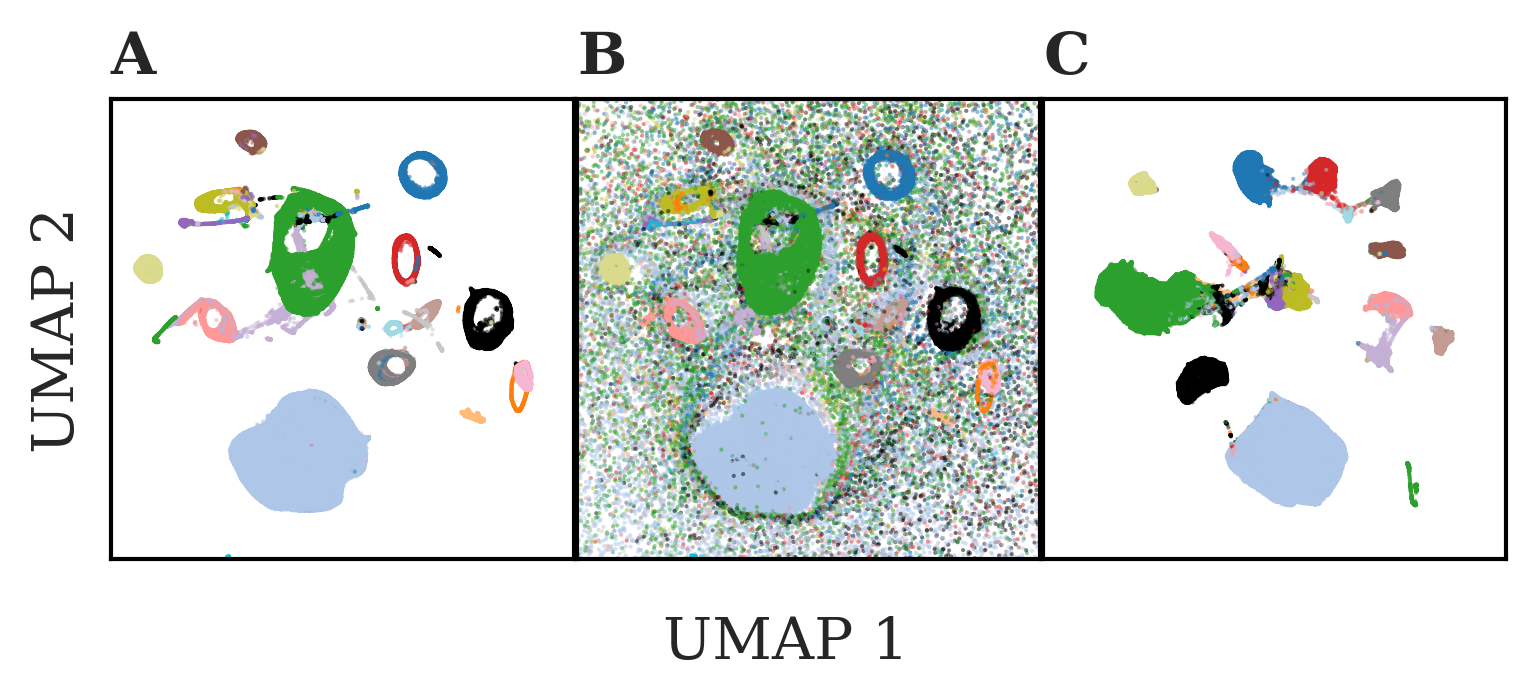

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid

def syllable_to_phrase_labels(arr, silence=0):
    new_arr = np.array(arr, dtype=int)
    length = len(new_arr)
    if length == 0:
        return new_arr
    def find_silence_runs(labels):
        runs = []
        in_silence = False
        start = None
        for i, val in enumerate(labels):
            if val == silence and not in_silence:
                in_silence = True
                start = i
            elif val != silence and in_silence:
                runs.append((start, i - 1))
                in_silence = False
        if in_silence:
            runs.append((start, length - 1))
        return runs
    silence_runs = find_silence_runs(new_arr)
    for start_idx, end_idx in silence_runs:
        left_label = new_arr[start_idx - 1] if start_idx > 0 else None
        right_label = new_arr[end_idx + 1] if end_idx < length - 1 else None
        if left_label is None and right_label is None:
            continue
        elif left_label is None:
            new_arr[start_idx:end_idx+1] = right_label
        elif right_label is None:
            new_arr[start_idx:end_idx+1] = left_label
        elif left_label == right_label:
            new_arr[start_idx:end_idx+1] = left_label
        else:
            for i in range(start_idx, end_idx + 1):
                dist_left = i - (start_idx - 1)
                dist_right = (end_idx + 1) - i
                if dist_left < dist_right:
                    new_arr[i] = left_label
                elif dist_right < dist_left:
                    new_arr[i] = right_label
                else:
                    new_arr[i] = left_label
    return new_arr

ROOT = pathlib.Path().resolve()
RESULTS_DIR = ROOT / "results"

npz_files = [
    RESULTS_DIR / "fit_umap_train.npz",
    RESULTS_DIR / "transform_umap_test.npz", 
    RESULTS_DIR / "decoder_umap_test_coords.npz"
]

tab20 = plt.get_cmap('tab20')
# Use all 20 tab20 colors, with black for silence (label 0)
colors_list = ['black'] + [tab20(i) for i in range(20)]
custom_cmap = mpl.colors.ListedColormap(colors_list)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Computer Modern Roman", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1,
})

fig = plt.figure(figsize=(6., 2.5), dpi=300)
# Reduce axes_pad to minimize whitespace between panels and labels
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 3),
                 axes_pad=0.01,  # was 0.05, now much tighter
                 share_all=True,
                 cbar_location="right",
                 cbar_mode=None,
                 )

panel_labels = ['A', 'B', 'C']

for idx, (ax, npz_file, panel_label) in enumerate(zip(grid, npz_files, panel_labels)):
    if npz_file.exists():
        data = np.load(npz_file)
        coords = data['coords']
        if 'colors' in data:
            colors = data['colors']
        elif 'labels' in data:
            colors = data['labels']
        else:
            colors = 'black'
        if not isinstance(colors, str):
            colors = syllable_to_phrase_labels(colors)
        if isinstance(colors, str):
            ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=1, alpha=0.5, linewidths=0)
        else:
            # Map label values to colormap indices to avoid color repeats
            # Silence (0) is black, others are mapped to 1..20 (tab20)
            unique_labels = np.unique(colors)
            label_to_cmap_idx = {label: (i+1 if label != 0 else 0) for i, label in enumerate(unique_labels)}
            mapped_colors = np.array([label_to_cmap_idx[l] for l in colors])
            ax.scatter(coords[:, 0], coords[:, 1], c=mapped_colors, s=1, alpha=0.5, cmap=custom_cmap, linewidths=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        x_min, x_max = np.min(coords[:, 0]), np.max(coords[:, 0])
        y_min, y_max = np.min(coords[:, 1]), np.max(coords[:, 1])
        if idx == 1:
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
        else:
            x_pad = (x_max - x_min) * 0.15
            y_pad = (y_max - y_min) * 0.15
            ax.set_xlim(x_min - x_pad, x_max + x_pad)
            ax.set_ylim(y_min - y_pad, y_max + y_pad)
    else:
        ax.text(0.5, 0.5, f'File not found:\n{npz_file.name}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

# Move y-label closer to the panels
grid[0].set_ylabel('UMAP 2', fontsize=14, labelpad=6)

# Move 'UMAP 1' label closer to the panels
fig.text(0.5, 0.04, 'UMAP 1', ha='center', va='bottom', fontsize=14)

for ax, panel_label in zip(grid, panel_labels):
    # Place panel label in the top-left corner, above each panel
    ax.annotate(
        panel_label,
        xy=(0.0, 1.03), xycoords='axes fraction',
        ha='left', va='bottom',
        fontsize=14, fontweight='bold'
    )

plt.show()